In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style, cm
from sklearn.linear_model import LinearRegression
import matplotlib.ticker
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [14, 8]

In [5]:
df = pd.read_csv("C:\\Users\\Aman\\Desktop\\Aman\\crypto_finance\\BTC_USD.csv")[["Date", "Value"]]
df.Date = pd.to_datetime(df.Date)
df.sort_values(by="Date", inplace = True)
genesis = df.Date[len(df)-1]
#Genesis block is 3rd Jan, 2009, above value is actually 2nd Jan
df = df[df.Date >= "2010-09-16"]#useful data from exchanges from 2011 onwards
df=df.reset_index()
df=df.drop("index", axis=1)
delta = (df.Date[0] - genesis).days - 1
#728 days between Jan 1, 2011 and Jan 3, 2009

In [6]:
(df.Date[0] - genesis).days

622

In [7]:
df["ind"] = [x+delta for x in range(len(df))]
df #index represents number of days since genesis block

,Date,Value,ind
0,2010-09-16,0.150000,621
1,2010-09-17,0.060900,622
2,2010-09-18,0.062599,623
3,2010-09-19,0.060000,624
4,2010-09-20,0.063300,625
...,...,...,...
4047,2021-10-15,57397.740000,4668
4048,2021-10-16,61641.170000,4669
4049,2021-10-17,60948.780000,4670
4050,2021-10-18,61546.210000,4671


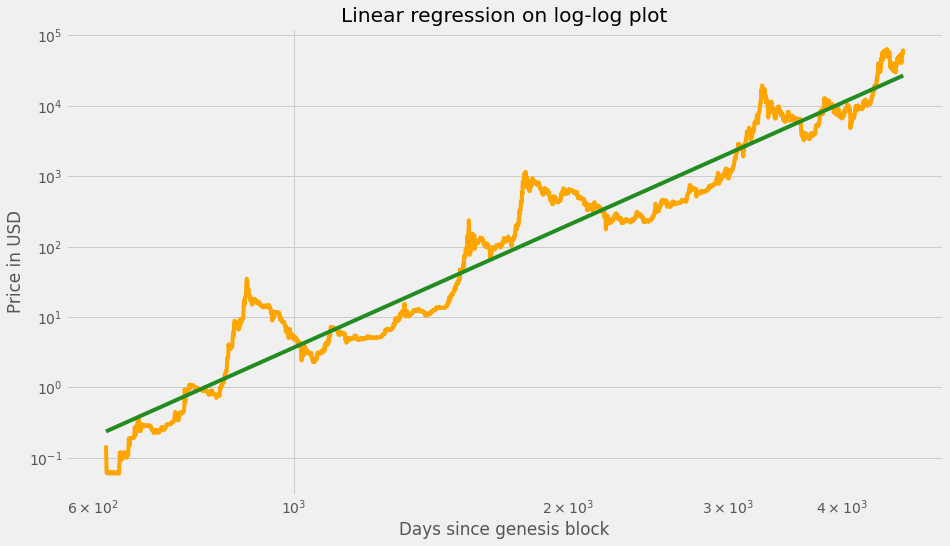

In [88]:
plt.style.use("fivethirtyeight")
reg = LinearRegression().fit(X,y)
fig, ax = plt.subplots()
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax.loglog(df.ind, df.Value, color = "orange") #plots ind and Value on log axes (values aren't log)

#linear regression - but based on the log-log graph so need to take log of values first 
X = np.array(np.log10(df.ind)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
y = np.array(np.log10(df.Value))
#now X and y are how they look on a log-log chart

ax.plot(np.power(10,X), np.power(10,reg.predict(X)), color = "forestgreen") #plot the X and predicted y as per X
plt.title("Linear regression on log-log plot")
plt.xlabel("Days since genesis block")
plt.ylabel("Price in USD")
plt.show()

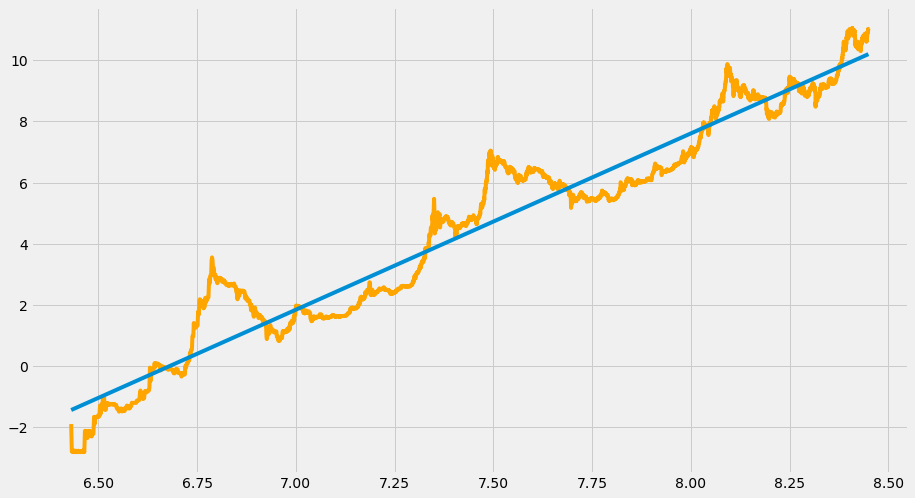

In [11]:
plt.style.use("fivethirtyeight")
plt.plot(np.log(df.ind), np.log(df.Value), color = "orange") #plots ind and Value on log axes (values aren't log)

#linear regression - but based on the log-log graph so need to take log of values first 
X = np.array(np.log(df.ind)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
y = np.array(np.log(df.Value))

#now X and y are how they look on a log-log chart
reg = LinearRegression().fit(X,y)

#remember plt plots on a linear axis and our X and y have been "logged"
plt.plot((X), (reg.predict(X))) #plot the X and predicted y as per X
plt.show()

In [12]:
def get_value(days):
    df1 = df[:days]
    X = np.array(np.log10(df1.ind)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
    y = np.array(np.log10(df1.Value))

    #now X and y are how they look on a log-log chart
    reg = LinearRegression().fit(X,y)
    #now need the difference between price(in log form) and output
    return (reg.predict(X)[-1]) 


In [13]:
oss_values = np.log10(df.Value) - [get_value(x+1) for x in range(len(df))]
oss_values = list(oss_values)

<class 'list'>
1174 0.9618260883557936


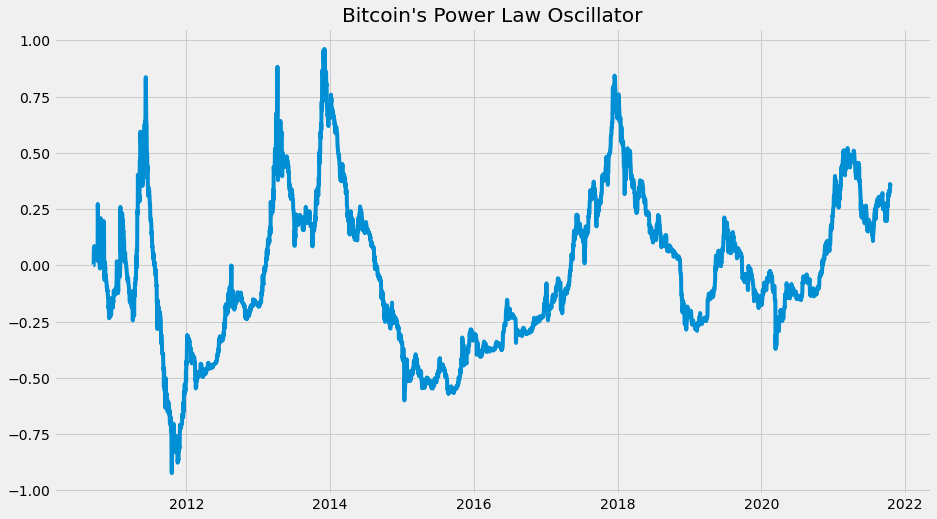

In [14]:
print(type(oss_values))
plt.plot(df.Date, oss_values)
plt.title("Bitcoin's Power Law Oscillator")
#plt.plot(df.Date, df.Value)
print(oss_values.index(max(oss_values)), max(oss_values))

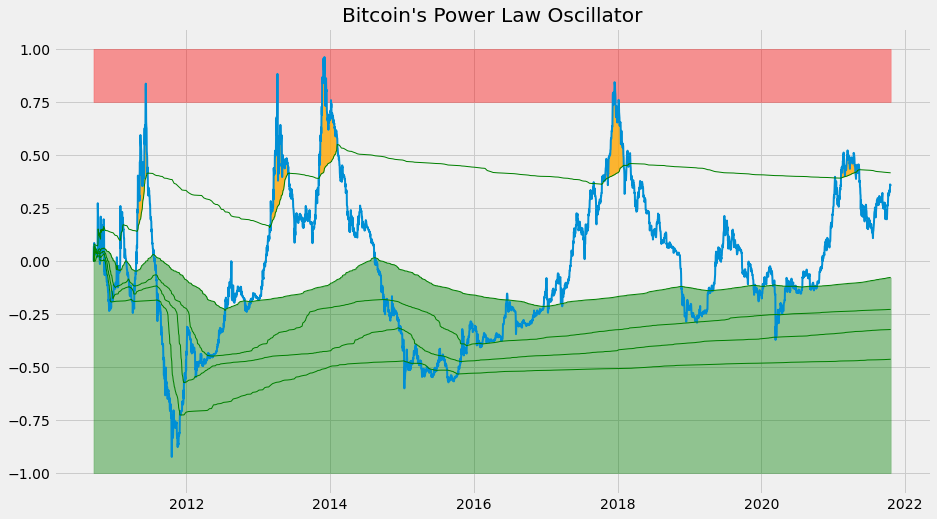

In [61]:
#add percentiles

df["ossvalues"] = oss_values
df["10cent"] = df["ossvalues"].expanding().quantile(0.1)
df["20cent"] = df["ossvalues"].expanding().quantile(0.2)
df["30cent"] = df["ossvalues"].expanding().quantile(0.3)
df["40cent"] = df["ossvalues"].expanding().quantile(0.4)
df["50cent"] = df["ossvalues"].expanding().quantile(0.5)
df["60cent"] = df["ossvalues"].expanding().quantile(0.6)
df["70cent"] = df["ossvalues"].expanding().quantile(0.7)
df["80cent"] = df["ossvalues"].expanding().quantile(0.8)
df["90cent"] = df["ossvalues"].expanding().quantile(0.9)

plt.title("Bitcoin's Power Law Oscillator")
plt.plot(df.Date, oss_values, linewidth=2)
plt.plot(df.Date, df["10cent"], color="green", linewidth=1)
plt.plot(df.Date, df["20cent"], color="green", linewidth=1)
plt.plot(df.Date, df["30cent"], color="green", linewidth=1)
plt.plot(df.Date, df["50cent"], color="green", linewidth=1)
plt.plot(df.Date, df["90cent"], color="green", linewidth=1)

plt.fill_between(df.Date, -1, df["50cent"], color="green", alpha=0.4) #(x_values, line #1, line #2, color)
plt.fill_between(df.Date, 0.75, 1, color="red", alpha=0.4)
plt.fill_between(df.Date, oss_values, df["90cent"], color="orange", where = list(oss_values > df["90cent"]), alpha=0.8)
plt.show()

In [53]:
df.loc[900]

Date         2013-03-04 00:00:00
Value                      34.25
ind                         1521
ossvalues               0.142812
10cent                 -0.585437
20cent                 -0.451246
30cent                 -0.364613
50cent                 -0.180104
90cent                  0.166576
40cent                 -0.220148
60cent                 -0.141863
70cent                -0.0756292
80cent                 0.0240007
Name: 900, dtype: object

In [54]:
def get_pctile_range(row):
    ossvalue = row.ossvalues
    ten = row["10cent"]
    twenty = row["20cent"]
    thirty = row["30cent"]
    forty = row["40cent"]
    fifty = row["50cent"]
    sixty = row["60cent"]
    seventy = row["70cent"]
    eighty = row["80cent"]
    ninety = row["90cent"]
    print(ossvalue)
    if ossvalue <= ten:
        return 1
    if ossvalue <= twenty:
        return 2
    if ossvalue <= thirty:
        return 3
    if ossvalue <= forty:
        return 4
    if ossvalue <= fifty:
        return 5
    if ossvalue <= sixty:
        return 6
    if ossvalue <= seventy:
        return 7
    if ossvalue <= eighty:
        return 8
    if ossvalue <= ninety:
        return 9
    return 10

In [55]:
daily_pctile = []
for i in range(len(df)):
    daily_pctile.append(get_pctile_range(df.loc[i]))

0.0
-2.6423307986078726e-14
0.06724049159691359
0.07156982802655398
0.08521261127177238
0.07493618030145877
0.05797108216103175
0.06963315972760276
0.061201372229436446
0.045264431079999445
0.0560348205783181
0.0543288841024554
0.036015948047520174
0.046499389094830645
0.04410866436805616
0.030504597665327315
0.0386678647322074
0.04033154715676224
0.026572704885136522
0.04580234863416277
0.04511018040911274
0.01934962912822491
0.27241545842109915
0.2309962417398822
0.1951414619095836
0.09242143036514539
0.060266936707233265
0.06709365495277808
0.11926417105952125
0.06526149819603133
0.08787738866028472
0.01233664630046083
0.0019365956796940642
-0.014198496455165355
0.014006937425898647
-0.0014487236079238075
0.0026885583981371974
0.20927595674459465
0.08860111869498855
0.1438787264223218
0.14336120738242297
0.12143008539832434
0.10129914352076608
0.08680311106519545
0.08396303456228105
0.04839846328212272
0.045553950098527474
0.16793134930567155
0.036024354099701617
0.07575420832345947

-0.5616547265030315
-0.57483493218155
-0.5284398421381605
-0.5615477212217763
-0.560748639375374
-0.5464809294544358
-0.5560834851115964
-0.5337296860343154
-0.46853732753226796
-0.5162799892916852
-0.4264121632183919
-0.4433611150091895
-0.43056112378782363
-0.3614929796506178
-0.31009069583536675
-0.3498110764741581
-0.3130160881701234
-0.3139989693508025
-0.31497126649659934
-0.3196618618449816
-0.32918843892564276
-0.3237399418833775
-0.34642484852774336
-0.3320825278147488
-0.3441520392980859
-0.33425155877549506
-0.33690756257248267
-0.33644490610104694
-0.3620508792835231
-0.3646129192935891
-0.3638682158886931
-0.37206529134385835
-0.36857622706252346
-0.3720973667809855
-0.390984545244065
-0.4284481488969515
-0.3998853631369068
-0.4235026838024438
-0.43578425373175766
-0.4266834619536801
-0.43301430364540683
-0.39208825463853936
-0.423424514398945
-0.4066818794179421
-0.40961411451560115
-0.40783410458441083
-0.42869761606421064
-0.41836127863270156
-0.4266405960508469
-0.4130

0.06621321456883345
0.02655576827342987
0.0717607895505894
0.04606970723134096
0.07359779455348536
0.09349140327477112
0.10684125074884299
0.10019432489801172
0.11879298058933152
0.09363840408760615
0.10984069941989416
0.10419193263569282
0.1154983022626268
0.10272715534439114
0.14296964506619458
0.15849151719874754
0.1372599239366623
0.1448562223095451
0.17057972510071528
0.14281217679958869
0.28241540339909244
0.2317910312086615
0.22450805044237732
0.2617698509830422
0.26400118881534196
0.26563505070113536
0.24527851301891368
0.2598001674528436
0.23390753577167467
0.2593729269375791
0.2557605541045411
0.2515132707848313
0.2560809288802306
0.33703442078069124
0.28996984884891464
0.4380529882557602
0.42139417501014576
0.41086441558010045
0.407080493951518
0.42701093501319987
0.41247437826134226
0.5012799204857266
0.5202487046016886
0.49437907133983705
0.5018223630970846
0.5057249768305743
0.5025393294304215
0.5693277108384125
0.6715594541215899
0.5951392495632581
0.6796490865729456
0.6

-0.004887455548367559
-0.015926547122968593
-0.010614822411812774
-0.009829196091932335
-0.01582882674067365
-0.042447202580123466
-0.03963825829733336
-0.044347859006589996
-0.051258260225088836
-0.0406181855364105
-0.05234805737672854
-0.04769697013330987
-0.04945606379143008
-0.05171690302981036
-0.06505413414353578
-0.04945110050968404
-0.06134398548897879
-0.06532890957554205
-0.05802169985375594
-0.0640890448239162
-0.0647639949912393
-0.07276512776770305
-0.07142817206087937
-0.11384705492955183
-0.14575387011958707
-0.11882565470614148
-0.14007374633500325
-0.14691694401665822
-0.14784933756137653
-0.11694351642332945
-0.14271744059164782
-0.12758180552359955
-0.15286054931952187
-0.17699202261865565
-0.155389262988046
-0.17610105441743418
-0.17421655525523194
-0.16978162607442737
-0.20124234811333297
-0.23663051392824785
-0.2089776563046688
-0.24476711313484234
-0.24632571714603246
-0.2512943059486634
-0.18910087134266806
-0.21358168904908714
-0.20898144674483587
-0.2085045064

-0.45477659105810186
-0.44669492564817403
-0.4136087517735483
-0.43875242587009167
-0.44011728725364296
-0.3997656094675719
-0.3209207453579559
-0.32623577414229077
-0.3315956796484727
-0.3448787278846681
-0.36207636698140133
-0.35354736028754497
-0.35710277159616455
-0.355482811734646
-0.4450722669582672
-0.4160443650341863
-0.40452948090203744
-0.41639837736515295
-0.4294477658782241
-0.43433347135336264
-0.41217811357787415
-0.4144740660172781
-0.4158770521772426
-0.43352539725160044
-0.42722935869106893
-0.42657510489274664
-0.42934457422291894
-0.4342379689488425
-0.43654558199071536
-0.40001290836236514
-0.38625164142435064
-0.38851864182634355
-0.3817372517267228
-0.37208140918718513
-0.36702585398823384
-0.3865994961991972
-0.3851929821839275
-0.38682025289362
-0.35423740460985087
-0.3546903999273816
-0.35819923619842964
-0.3501200733737213
-0.33018549754391247
-0.32808483450669446
-0.3005584443871214
-0.31926036465768526
-0.30956633440372494
-0.3008408899706434
-0.288073010171

-0.16516596844264253
-0.16593370903624072
-0.16762152948397802
-0.16951681729129087
-0.1487406566004159
-0.14447646356684896
-0.1527099845710156
-0.12923247697842433
-0.13309821258335797
-0.13353668495788984
-0.11289283552577789
-0.1169312818452326
-0.11650457428142724
-0.10853244324294753
-0.10244610563450562
-0.10576254799291362
-0.12053279318358134
-0.11923640837328664
-0.12534953117576553
-0.11987012798693142
-0.11371092786019865
-0.12478025578720464
-0.1105590276697499
-0.10281427194534176
-0.10522804202992786
-0.09729646912637957
-0.09909071337377329
-0.10569184655996722
-0.09305155955086075
-0.08375292824549874
-0.0914631007303015
-0.07778437000653993
-0.0772572023000766
-0.07857285094607658
-0.05268217829784838
-0.04282904848444069
-0.0448956910669831
-0.02777473026061994
-0.021361440984999813
-0.026244477008177558
-0.02211367822138932
0.005770280218001744
0.007763918499456235
0.03541030365795805
0.04867368891270951
0.049758648459461874
0.03518554580741773
0.035458202821765816


0.09339525163359497
0.086055179302166
0.09286583235253332
0.09069639368449911
0.08784975419307539
0.09549269352469825
0.09248363678420546
0.09723937524160142
0.09069028898984843
0.10152848307479134
0.08591098821362975
0.09784043876943338
0.1085386984400114
0.10894019773579133
0.10690129906722934
0.12385139824203328
0.12784085537218726
0.11799622295131407
0.12024821372975492
0.1217076995329407
0.13482223816646677
0.1347634510137916
0.13417336181059092
0.12416280797889279
0.07975365101163234
0.08352716390335191
0.07363059369172875
0.06738898059305987
0.06347052512109208
0.06653438095362718
0.06416462818984314
0.06704147470787136
0.07797963028435317
0.07850598814079524
0.07797454833551098
0.06901715734761105
0.061141121360550166
0.06352010889243775
0.06793524002486206
0.08383788902344946
0.08862081184883408
0.08488937634942806
0.07948062140609302
0.07503607228113474
0.06662770525175965
0.07032196212841235
0.07943713354708493
0.06976865063061632
0.07181646943589026
0.07222137690202901
0.06

-0.1302437266713632
-0.1297414747145922
-0.141057250013775
-0.14851476871513158
-0.15012145801425136
-0.1514095090956804
-0.14813457713736788
-0.15979126342099903
-0.15762147352646405
-0.17247787750293098
-0.19015852228894525
-0.14860782849298015
-0.15712548161800743
-0.15523470203065148
-0.1585682886555122
-0.1370708618890344
-0.1488261900178829
-0.15357221671735966
-0.15754591028094334
-0.15793153805472837
-0.15544081599843862
-0.15251972972632988
-0.14802926949292994
-0.15837393288561463
-0.16195336454366904
-0.1619899828335103
-0.17669349365354448
-0.1539253592132277
-0.15314004939736137
-0.15341191024555867
-0.13048062488457912
-0.10884385766724947
-0.1159451998595924
-0.1287619234865076
-0.10937686627069398
-0.11863916865945345
-0.11098394581798088
-0.11517033851995517
-0.07791435951227177
-0.07986542705938993
-0.08495876027833438
-0.07671954720800311
-0.0767566434602256
-0.08752959852923947
-0.09192050310165589
-0.087664960191848
-0.09136649036706856
-0.10569261540792008
-0.1041

0.24631271803701793
0.24846974207300132
0.2144243351654671
0.2607143478467071
0.2564056270573243
0.2652397697089244
0.25533982242689124
0.22233569057906077
0.2087744409640182
0.22087948444331218
0.2395158695371773
0.23119953780760483
0.24127774106836863
0.2586927156354957
0.23168040278186375
0.21472788171293455
0.21750879709553228
0.1879894049202706
0.18647384735502115
0.23352144163277888
0.2253830561418253
0.23181757152714866
0.20942928198733135
0.25035123052131425
0.2655442387231153
0.2611877072606452
0.23985345172930828
0.23622341958913395
0.20800349735428103
0.2048087132098484
0.20495357322430685
0.15381942208257193
0.16346793983161856
0.1789192142302598
0.19050874436848453
0.15053339623877715
0.15696331250616513
0.1885930164730496
0.18555923052930456
0.20206257205169553
0.19157928106813582
0.1717830773268334
0.17524129729438442
0.1851136884407234
0.19213410822238597
0.17182958347974697
0.1770812740640526
0.17167070723791245
0.1584967428605033
0.1700923816098161
0.16552629538202268

In [58]:
get_pctile_range(df.loc[195])

-0.18517813277090073


1

In [59]:
len(daily_pctile), len(df.Value)

(4052, 4052)

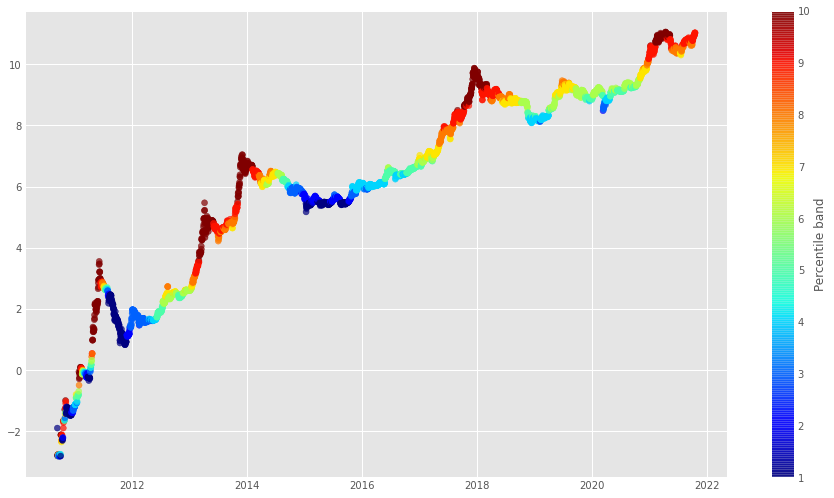

In [92]:
plt.style.use("ggplot")
plt.scatter(df.Date, np.log(df.Value), c = daily_pctile, cmap = cm.jet, alpha = 0.7)
plt.colorbar(label = 'Percentile band')


In [27]:
def get_furthest_x(y, line):
    #y is all the log of values 
    # line is the linear regression line
    difference = [abs(y[x] - line[x]) for x in range(len(line))]
    max_difference = max(difference)
    return difference.index(max_difference)

In [28]:
def perform_regression(df):
    X = np.array(np.log(df.ind)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
    y = np.array(np.log(df.Value))

    #now X and y are how they look on a log-log chart
    reg = LinearRegression().fit(X,y)

    #remember plt plots on a linear axis and our X and y have been "logged"
    #plt.plot((X), (reg.predict(X))) #plot the X and predicted y as per X
    line = reg.predict(X)
    outlier = get_furthest_x(y, line) #index of furthest element from line
    return outlier

In [29]:
df2 = df
iterations = int(len(df2)/2)
print(iterations)
for i in range(0,iterations):
    outlier = perform_regression(df2)
    #outlier is the xth index from beginning, we need to drop it
    df2=df2.drop(df2.index[outlier])

2026


Text(0.5, 1.0, 'RANSAC non-bubble data')

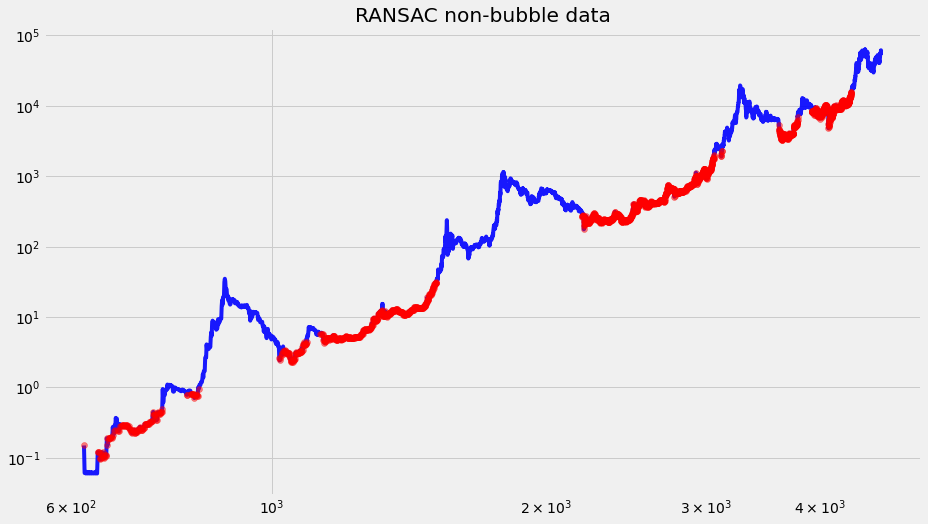

In [30]:
plt.loglog(df.ind, df.Value, alpha=0.9, color="blue", zorder=1)
plt.scatter(df2.ind, df2.Value, color='red', alpha=0.5, zorder=2)
plt.title("RANSAC non-bubble data")